<a href="https://colab.research.google.com/github/Jorbnc/MAIA-DL/blob/master/Mini_Proyecto_3_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

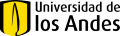

<style>
@import url('https://fonts.googleapis.com/css2?family=Latin+Modern+Roman:wght@400;700&display=swap');

body, p, h1, h2, h3, h4, h5, h6, li {
  font-family: 'Latin Modern Roman', serif;
}
code, pre {
  font-family: 'Fira Mono', monospace;
}
</style>

***

# **Miniproyecto 3, Técnicas de *Deep Learning*: ...**

## **Descripción del problema:**

...

## **Objetivo:**

...

***

**Este proyecto es realizado por Andrés Felipe Ñungo y Jordan Bryan Núñez Campos para entrega el 13 de mayo de 2025.**



***
# **Índice**

El *notebook* aborda el proyecto con la siguiente estructura:

| 🔹 | Sección        |
|----|----------------|
| 1️⃣. | **Instalación y carga de librerías** |
| 1️⃣.1️⃣. | **Word2Vec** |
| 1️⃣.2️⃣. | **GloVe** |
| 1️⃣.3️⃣. | **Configuraciones adicionales** |
| 2️⃣. | **Análisis exploratorio y preparación de los datos**       |
| 2️⃣.1️⃣. | **Carga y estadísticas generales**       |
| 2️⃣.2️⃣. | **Limpieza de los datos**       |
| 3️⃣. | **Definición de *pipelines* de procesamiento**          |
| 3️⃣.1️⃣. | **Pipeline de preprocesamiento**   |
| 4️⃣. | **Desarrollo del modelo RNN**   |
| 4️⃣.1️⃣. | **Hiperparámetros, Partición y DataLoaders**   |
| 4️⃣.2️⃣. | **Definición del modelo**   |
| 4️⃣.3️⃣. | **Entrenamiento, validación y prueba**   |
| 5️⃣. | **Análisis de resultados y discusión**   |
| 5️⃣.1️⃣. | **Pruebas individuales del modelo**   |
| 6️⃣. | **Conclusión**   |
| 7️⃣. | **Referencias**   |


***

# 1. Instalación y carga de librerías

....

In [1]:
# Instalación de librerías necesarias para correr en Colab/Coursera
!pip -q install kagglehub langdetect matplotlib scikit-learn plotly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 14.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [28]:
# Librerías comunes
import os, random, gc, copy, time, pickle, math
import subprocess
from pathlib import Path
import numpy as np
import pandas as pd
from collections import defaultdict

# Descarga de datasets y de embeddings
import kagglehub

# Limipieza y preparación de los txtos
from langdetect import detect, DetectorFactory
import re

# Preprocesamiento y herramientas de PLN
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from transformers import (BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup,
                          AutoTokenizer, AutoModelForSequenceClassification,)

# Modelado
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW


# Evaluación
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,   # 👈
    recall_score,      # 👈
    classification_report
)

# Librerías para visualizaciones
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.metrics import confusion_matrix   # 👈 NUEVO
import itertools                                # 👈 para anotar cada celda

Uses “bert-base-uncased” version of BERT, which is pre-trained on lower-cased English text

(with 12-layer, 768-hidden, 12-heads, 110M parameters)

For the purposes of fine-tuning, the authors recommend choosing from the following values (from Appendix A.3 of the BERT paper: https://arxiv.org/pdf/1810.04805.pdf):

*   **Batch size:** 16, 32
*   **Learning rate (Adam):** 5e-5, 3e-5, 2e-5
*   **Number of epochs:** 2, 3, 4

[1]

In [3]:
#Parámetros globales de los modelos
TEXT_COL   = "text"
LABEL_COL  = "labels"                    # columna con la categoría en texto
MAX_LEN    = 256
BATCH_SIZE = 16
EPOCHS     = 6
PATIENCE   = 2
UNFREEZE_PER_EPOCH = 2                 # capas a liberar por época
SEED = 13

Se descarga el conjunto de datos de reseñas de noticias de la BBC de **`kagglehub`**. La función **`dataset_download`** guarda los archivos de manera local y devuelve la ruta absoluta, que se almacena en **`path`** y se muestra en pantalla mediante **`print`** para confirmar dónde quedaron los datos.

## 1.3. Configuraciones adicionales

Con el siguiente bloque se detecta si el entorno dispone de GPU y selecciona el **`device`** apropiado para PyTorch.  

Primero se llama a **`is_available()`**, que devuelve *True* si se ha asignado una GPU CUDA al *runtime* de Colab. Según el resultado se imprime un mensaje informativo. Posteriormente, se construye el objeto **`device`**, que será pasado a la red y a los tensores de entrada para que se ubiquen en la GPU cuando sea posible. Por último se muestra en pantalla el dispositivo elegido.

In [4]:
# Devuelve asignación de GPU
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo activo → {DEVICE}")

Dispositivo activo → cuda


Adicionalmente se ocultan avisos para mantener limpias algunas salidas del notebook; y se imprimen las versiones de un conjunto de librerías clave ( **`numpy`**, **`pandas`**, **`torch`**, **`scikit-learn`**, **`kagglehub`**, **`matplotlib`**). Mostrar estas versiones al inicio del notebook facilita la reproducibilidad y ayuda a depurar posibles conflictos de dependencias.

In [5]:
# Ignorar las warnings
import warnings
warnings.filterwarnings("ignore")

# Versiones utilizadas
from importlib.metadata import version
librerias = ["numpy", "pandas", "torch", "scikit-learn", "kagglehub","matplotlib"]
for library in librerias:
  print(library, ": ", version(library))

numpy :  2.0.2
pandas :  2.2.2
torch :  2.6.0+cu124
scikit-learn :  1.6.1
kagglehub :  0.3.12
matplotlib :  3.10.0


Finalmente, para cerrar esta sección se configuran algunas semillas para tener cierto grado de control en la aleatoriedad.

In [6]:
# Definición del random state y seeds

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark     = False

***

# 2. Análisis exploratorio y preparación de los datos


***

## 2.1. Carga y estadísticas generales

In [7]:
# Leer el conjunto de datos y cargarlo a un dataframe

# Descarga del conjunto de datos
path = kagglehub.dataset_download("jacopoferretti/bbc-articles-dataset")
print("Datos descargados en:", path)

CSV_PATH = os.path.join(path, "bbc_news_text_complexity_summarization.csv")
print(f"Dataset descargado en: {CSV_PATH}")

data_raw = pd.read_csv(CSV_PATH)
print("Filas totales:", len(data_raw))

Datos descargados en: /kaggle/input/bbc-articles-dataset
Dataset descargado en: /kaggle/input/bbc-articles-dataset/bbc_news_text_complexity_summarization.csv
Filas totales: 2127


***

## 2.2. Limpieza de los datos

En estas sección identificamos y corregimos:

* Valores faltantes
* Textos duplicados
* Textos en otros idiomas distintos al inglés

In [8]:
data_raw.isna().sum()

,0
text,0
labels,0
no_sentences,0
Flesch Reading Ease Score,0
Dale-Chall Readability Score,0
text_rank_summary,0
lsa_summary,0


In [9]:
data_raw.duplicated().sum()

np.int64(0)

In [10]:
df = data_raw.copy()

In [11]:
# 2.1. Carga y estadísticas  ➜  justo después de copiar el DataFrame

le = LabelEncoder()
df["label_id"] = le.fit_transform(df[LABEL_COL])

NUM_LABELS = len(le.classes_)      # 👈  siempre un entero

id2label = {i: lbl for i, lbl in enumerate(le.classes_)}
label2id = {v: k for k, v in id2label.items()}

In [12]:
# Gráfica para mostrar distribución de las clases

In [13]:
def detectar_idiomas(df: pd.DataFrame,
                     col_texto: str = 'text') -> pd.DataFrame:
    """
    Detecta el idioma de cada fila en la columna **col_texto**,
    añade la columna **idioma** y muestra ejemplos no ingleses.
    """
    # Inicializamos con 'desconocido'
    df['idioma'] = 'desconocido'

    # Función auxiliar segura
    def _detectar(texto):
        if isinstance(texto, str) and texto.strip():
            try:
                return detect(texto)
            except Exception:
                return 'desconocido'
        return 'desconocido'

    # Aplicamos detección
    df['idioma'] = df[col_texto].apply(_detectar)

    # Filtramos los que no son inglés
    mask = df['idioma'] != 'en'
    idx_no_en = df[mask].index

    if len(idx_no_en) > 0:
        print(f"Se encontraron {len(idx_no_en)} textos NO en inglés (ejemplos):")
        # Mostramos hasta 5 ejemplos
        for i in idx_no_en[:5]:
            print(f" • Índice {i}: [{df.at[i,'idioma']}] {df.at[i,col_texto][:100]}...")
    else:
        print("Todos los textos están detectados como inglés.")

    return df

Nota: En algunas ocasiones, la función `detect` confunde la presencia de nombres propios o pequeñas secciones en otros idiomas como un indicativo de que el texto no está en inglés. Sin embargo, estas ocurrencias suelen ser mínimas o nulas.

Detectando otros idiomas:

In [14]:
df = detectar_idiomas(df, col_texto='text')

Todos los textos están detectados como inglés.


***

# 3. Definición de *pipelines* de procesamiento

***

## 3.1. *Pipeline* de preprocesamiento

....

In [15]:
# Limpieza básica
def clean_text(text: str) -> str:
    text = re.sub(r"\s+", " ", text)            # colapsar whitespace
    text = re.sub(r"[^\w.,;:!?()¿¡ ]+", "", text)
    return text.strip()

for col in ("text", "text_rank_summary", "lsa_summary"):
    if col in df.columns:
        df[col] = df[col].astype(str).apply(clean_text)


In [17]:
train_df, test_df = train_test_split(
    df, test_size=0.10, stratify=df["label_id"], random_state=SEED
)
train_df, val_df = train_test_split(
    train_df, test_size=0.10, stratify=train_df["label_id"], random_state=SEED
)
print("Tamaños – Train / Val / Test:", len(train_df), len(val_df), len(test_df))

Tamaños – Train / Val / Test: 1722 192 213


[2]

***

# 4. Desarrollo del modelo RNN

***

## 4.1. Hiperparámetros, partición y *DataLoaders*

...

In [18]:
class BBCDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.texts  = df[TEXT_COL].tolist()
        self.labels = df["label_id"].tolist()
        self.tok    = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        enc = self.tok(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )
        item = {k: v.squeeze(0) for k, v in enc.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

In [19]:
def build_dataloaderss(splits, tokenizer, max_len, batch_size, num_workers=2):
    """Crea DataLoaders evitando referencias fantasma."""
    return {
        k: DataLoader(
            BBCDataset(df_split, tokenizer, max_len),
            batch_size=batch_size,
            shuffle=(k == "train"),
            num_workers=num_workers,
            pin_memory=True,
        )
        for k, df_split in splits.items()
    }

In [20]:
def make_loader(df, tokenizer, split: str,
                batch_size: int, max_len: int,
                num_workers: int = 2):
    """
    Devuelve un DataLoader para un único DataFrame.
    """
    ds = BBCDataset(df, tokenizer, max_len)
    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=(split == "train"),
        num_workers=num_workers,
        pin_memory=True,
    )

In [21]:
# -----------------------------------------------------
# 4. Utilidades de congelado / descongelado
# -----------------------------------------------------

def freeze_encoder(model, freeze: bool = True):
    """Congela o descongela todo el encoder base."""
    for param in model.base_model.parameters():
        param.requires_grad = not freeze

def unfreeze_last_n_layers(model, n: int):
    """Activa gradientes en las *n* últimas capas del encoder."""
    if not hasattr(model.base_model, "encoder"):
        return  # modelos tipo RoBERTa/BERT comparten estructura
    layers = model.base_model.encoder.layer
    for layer in layers[-n:]:
        for p in layer.parameters():
            p.requires_grad = True

In [22]:
# -----------------------------------------------------
# 4. Función train_and_evaluate  >>> MODIFIED <<<
# -----------------------------------------------------


def train_and_evaluate(model_name: str, train_df, val_df, test_df):
    print(f"\n========== Entrenando {model_name} ==========")

    # Tokenizer + modelo
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=NUM_LABELS,
        id2label=id2label,
        label2id=label2id,
    ).to(DEVICE)

    # 5.1 Congelar encoder completo y luego liberar gradualmente
    freeze_encoder(model)

    # 5.2 Pesos de clase balanceados
    class_weights = compute_class_weight(
        class_weight="balanced", classes=np.arange(NUM_LABELS), y=train_df["label_id"]
    )
    class_weights = torch.tensor(class_weights, dtype=torch.float32, device=DEVICE)

    # 5.3 DataLoaders
    loaders = {
        "train": make_loader(train_df, tokenizer, "train", BATCH_SIZE, MAX_LEN),
        "val":   make_loader(val_df,   tokenizer, "val",   BATCH_SIZE, MAX_LEN),
        "test":  make_loader(test_df,  tokenizer, "test",  BATCH_SIZE, MAX_LEN),
    }

    # 5.4 Optimizador & scheduler
    total_steps = len(loaders["train"]) * EPOCHS
    optimizer   = AdamW(model.parameters(), lr=2e-5, weight_decay=1e-2)
    scheduler   = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=int(0.06 * total_steps),
        num_training_steps=total_steps,
    )

    criterion   = torch.nn.CrossEntropyLoss(weight=class_weights)

    best_f1, patience_cnt = 0.0, 0
    best_path = f"best_{model_name.split('-')[0]}_bbc.pt"

    def epoch_pass(split):
        is_train = split == "train"
        model.train() if is_train else model.eval()
        losses, preds_all, trues_all = [], [], []

        for batch in loaders[split]:
            batch = {k: v.to(DEVICE) for k, v in batch.items()}
            with torch.set_grad_enabled(is_train):
                outputs = model(**{k: v for k, v in batch.items() if k != "labels"})
                loss = criterion(outputs.logits, batch["labels"])
                if is_train:
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                    optimizer.step(); scheduler.step(); optimizer.zero_grad()

            losses.append(loss.item())
            preds_all.extend(outputs.logits.argmax(dim=-1).cpu().numpy())
            trues_all.extend(batch["labels"].cpu().numpy())

        acc = accuracy_score(trues_all, preds_all)
        f1m = f1_score(trues_all, preds_all, average="macro", zero_division=0)
        f1µ = f1_score(trues_all, preds_all, average="micro", zero_division=0)
        return np.mean(losses), acc, f1m, f1µ

    # 5.5 Entrenamiento
    hist = {k: [] for k in ["epoch","train_loss","val_loss",
                        "train_acc","val_acc","train_f1","val_f1"]}
    for epoch in range(1, EPOCHS + 1):
        unfreeze_last_n_layers(model, epoch * UNFREEZE_PER_EPOCH)
        train_loss, train_acc, train_f1m, train_f1µ = epoch_pass("train")
        val_loss,   val_acc,   val_f1m,   val_f1µ   = epoch_pass("val")
        hist["epoch"].append(epoch)
        hist["train_loss"].append(train_loss); hist["val_loss"].append(val_loss)
        hist["train_acc"].append(train_acc);   hist["val_acc"].append(val_acc)
        hist["train_f1"].append(train_f1m);    hist["val_f1"].append(val_f1m)

        print(f"Ep {epoch:02d}: \tTL {train_loss:.4f} / VL {val_loss:.4f} | "
              f"F1_macro {val_f1m:.3f}  Acc {val_acc:.3f}")

        if val_f1m > best_f1:
            best_f1 = val_f1m
            patience_cnt = 0
            torch.save(model.state_dict(), best_path)
        else:
            patience_cnt += 1
            if patience_cnt == PATIENCE:
                print("Early stopping ↯\n")
                break

    # 5.6 Evaluación sobre *test*
    model.load_state_dict(torch.load(best_path))
    test_loss, test_acc, test_f1m, test_f1µ = epoch_pass("test")

    y_true, y_pred = [], []
    model.eval()
    with torch.no_grad():
        for batch in loaders["test"]:
            batch = {k: v.to(DEVICE) for k, v in batch.items()}
            outputs = model(**{k: v for k, v in batch.items() if k != "labels"})
            y_true.extend(batch["labels"].cpu().numpy())
            y_pred.extend(outputs.logits.argmax(dim=-1).cpu().numpy())

    # Precisión y recall (macro / micro)
    prec_macro = precision_score(y_true, y_pred, average="macro", zero_division=0)
    prec_micro = precision_score(y_true, y_pred, average="micro", zero_division=0)
    rec_macro  = recall_score   (y_true, y_pred, average="macro", zero_division=0)
    rec_micro  = recall_score   (y_true, y_pred, average="micro", zero_division=0)

    report = classification_report(
        y_true,
        y_pred,
        labels=list(range(NUM_LABELS)),
        target_names=le.classes_.tolist(),
        digits=3,
        zero_division=0,
    )

    # 5.7 Limpieza explícita
    del loaders, optimizer, scheduler, criterion
    gc.collect(); torch.cuda.empty_cache()

    metrics = {
        "model": model_name,
        "test_acc":       test_acc,
        "test_precision_macro": prec_macro,   # 👈
        "test_precision_micro": prec_micro,   # 👈
        "test_recall_macro":    rec_macro,    # 👈
        "test_recall_micro":    rec_micro,    # 👈
        "test_f1_macro":  test_f1m,
        "test_f1_micro":  test_f1µ,
        "report": report,
        "history": hist,
    }
    return metrics

....

***

## 4.3. Entrenamiento, validación y prueba

 **`gradient clipping`** m

In [23]:
if __name__ == "__main__":
    start = time.time()

    MODELS = {
        "bert-base-uncased": "BERT",
        "roberta-base": "RoBERTa",
    }

    results = []
    histories = {}
    for mdl_name, label in MODELS.items():
        m = train_and_evaluate(mdl_name, train_df, val_df, test_df)
        results.append(m)
        histories[label] = m["history"]
        print("\n>>> Reporte detallado:")
        print(m["report"])
        print("="*60)

    # tabla comparativa
    print("\n======= Comparativa final =======")
    for res in results:
        print(f"{MODELS[res['model']]:9s} | "
        f"Acc {res['test_acc']:.3f} | "
        f"P_macro {res['test_precision_macro']:.3f} | "
        f"R_macro {res['test_recall_macro']:.3f} | "
        f"F1_macro {res['test_f1_macro']:.3f}")

    dur = (time.time() - start) / 60
    print(f"\nTiempo total: {dur:.1f} min\n")


========== Entrenando bert-base-uncased ==========


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Ep 01: 	TL 1.2429 / VL 0.6070 | F1_macro 0.959  Acc 0.958
Ep 02: 	TL 0.3373 / VL 0.1647 | F1_macro 0.996  Acc 0.995
Ep 03: 	TL 0.1270 / VL 0.0922 | F1_macro 0.979  Acc 0.979
Ep 04: 	TL 0.0725 / VL 0.0675 | F1_macro 0.985  Acc 0.984
Early stopping ↯


>>> Reporte detallado:
               precision    recall  f1-score   support

     business      0.922     0.940     0.931        50
entertainment      1.000     1.000     1.000        37
     politics      0.951     0.975     0.963        40
        sport      1.000     0.980     0.990        51
         tech      0.971     0.943     0.957        35

     accuracy                          0.967       213
    macro avg      0.969     0.968     0.968       213
 weighted avg      0.968     0.967     0.967       213


========== Entrenando roberta-base ==========


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Ep 01: 	TL 1.3116 / VL 0.2185 | F1_macro 0.965  Acc 0.964
Ep 02: 	TL 0.1141 / VL 0.0574 | F1_macro 0.974  Acc 0.974
Ep 03: 	TL 0.0438 / VL 0.0455 | F1_macro 0.984  Acc 0.984
Ep 04: 	TL 0.0210 / VL 0.0589 | F1_macro 0.979  Acc 0.979
Ep 05: 	TL 0.0089 / VL 0.0990 | F1_macro 0.973  Acc 0.974
Early stopping ↯


>>> Reporte detallado:
               precision    recall  f1-score   support

     business      0.980     0.960     0.970        50
entertainment      1.000     1.000     1.000        37
     politics      0.951     0.975     0.963        40
        sport      1.000     1.000     1.000        51
         tech      1.000     1.000     1.000        35

     accuracy                          0.986       213
    macro avg      0.986     0.987     0.987       213
 weighted avg      0.986     0.986     0.986       213


======= Comparativa final =======
BERT      | Acc 0.967 | P_macro 0.969 | R_macro 0.968 | F1_macro 0.968
RoBERTa   | Acc 0.986 | P_macro 0.986 | R_macro 0.987 | F1_macro

In [24]:
def plot_history(hist):
    epochs = list(range(1,len(hist['train_loss'])+1))
    plt.figure(figsize=(8,4))
    plt.plot(epochs,hist['train_loss'],label='Train Loss')
    plt.plot(epochs,hist['val_loss'],label='Val Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss vs Epoch'); plt.legend(); plt.show()

    plt.figure(figsize=(8,4))
    plt.plot(epochs,hist['train_acc'],label='Train Acc')
    plt.plot(epochs,hist['val_acc'],label='Val Acc')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy vs Epoch'); plt.legend(); plt.show()


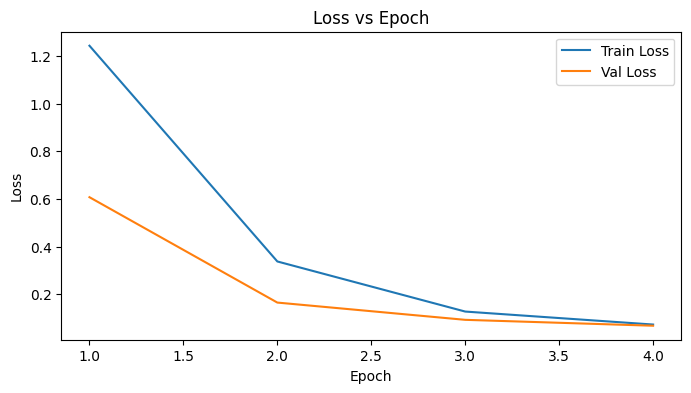

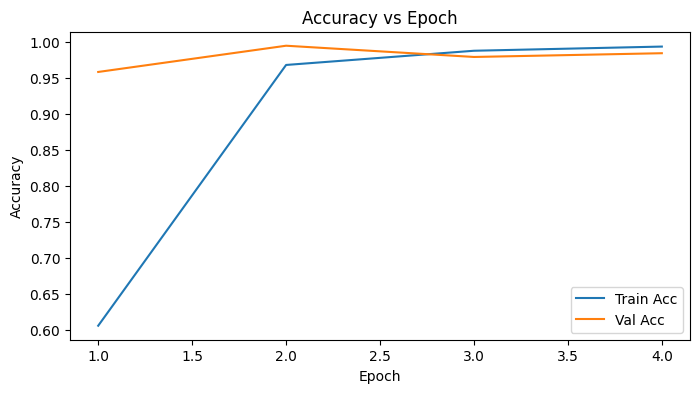

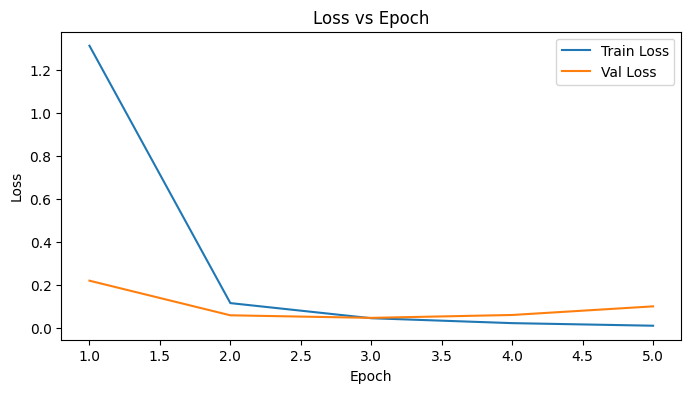

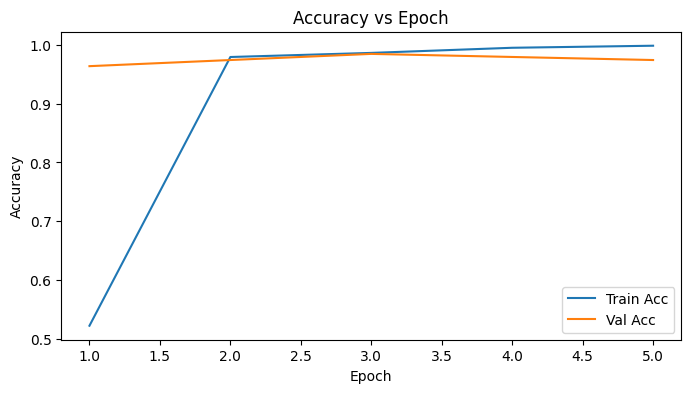

In [31]:
hist_bert = histories["BERT"]
hist_roberta = histories["RoBERTa"]
plot_history(hist_bert)         # igual que hist_bert
plot_history(hist_roberta)      # igual que hist_roberta

[3]

...

***


# 5. Análisis de resultados y discusión

...

...

In [29]:
# Mariz de confusión de ambos modelos
# -----------------------------------------------------
#  Función: plot_confusion_matrix
# -----------------------------------------------------
def plot_confusion_matrix(model, loader, label_names,
                          device=DEVICE,
                          normalize=True,
                          figsize=(6, 6)):
    """
    Dibuja la matriz de confusión (normalizada o cruda).

    Parámetros
    ----------
    model : torch.nn.Module
        Modelo fine-tuneado (BERT, RoBERTa, …) ya en modo eval().
    loader : DataLoader
        DataLoader del split que se evaluará (típico: test_loader).
    label_names : list[str]
        Lista ordenada con los nombres de las clases.
    device : torch.device
        Dispositivo donde corre la inferencia (default: DEVICE global).
    normalize : bool
        Si True, divide cada fila por su suma → porcentajes.
    figsize : tuple
        Tamaño del gráfico en pulgadas.
    """
    # 1) Recolectar predicciones y etiquetas reales
    y_true, y_pred = [], []
    model.eval()
    with torch.no_grad():
        for batch in loader:
            # Mover tensores al dispositivo
            batch = {k: v.to(device) for k, v in batch.items()}
            # Forward (excepto "labels")
            outputs = model(**{k: v for k, v in batch.items() if k != "labels"})
            # Acumular
            y_true.extend(batch["labels"].cpu().numpy())
            y_pred.extend(outputs.logits.argmax(dim=-1).cpu().numpy())

    # 2) Calcular matriz de confusión
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1, keepdims=True)

    # 3) Graficar
    import matplotlib.pyplot as plt  # local para evitar conflictos
    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(cm, interpolation="nearest", cmap="Blues")
    ax.figure.colorbar(im, ax=ax)

    # Ejes y títulos
    ax.set(
        xticks=range(len(label_names)),
        yticks=range(len(label_names)),
        xticklabels=label_names,
        yticklabels=label_names,
        ylabel="Etiqueta real",
        xlabel="Etiqueta predicha",
        title=f"Matriz de Confusión ({'normalizada' if normalize else 'cruda'})"
    )
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Anotar cada celda
    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

    fig.tight_layout()
    plt.show()

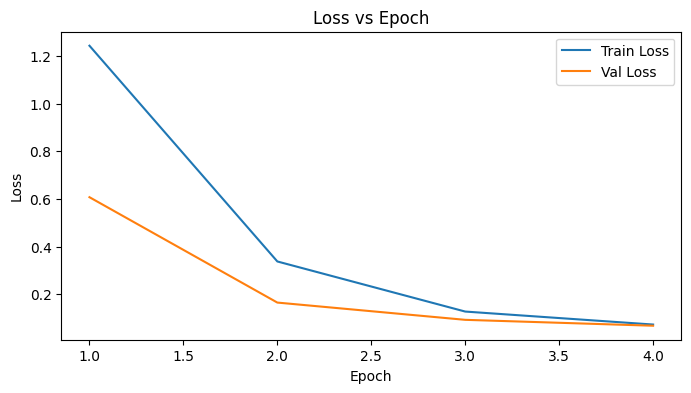

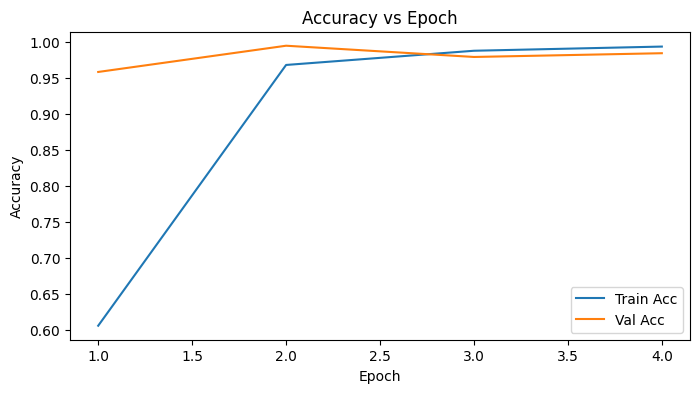

NameError: name 'model_bert' is not defined

In [32]:
plot_confusion_matrix(model_bert, test_loader, le.classes_.tolist())
plot_confusion_matrix(model_roberta, test_loader, le.classes_.tolist())

In [ ]:
# -----------------------------------------------------
#  Función: collect_fn_fp_examples
# -----------------------------------------------------
def collect_fn_fp_examples(model,
                           loader,
                           df_texts,          # pd.DataFrame con las columnas ["text", "label"]
                           label_names,        # lista ordenada igual que los IDs
                           device=DEVICE,
                           max_per_class=5):
    """
    Devuelve un DataFrame con ejemplos FP y FN por clase (máx. `max_per_class` cada uno).

    Requisitos
    ----------
    - El DataLoader debe iterar **en el mismo orden** que `df_texts`.
      Si tu `Dataset` no mantiene el índice original, añade `idx` dentro
      de __getitem__ y pásalo por el batch.
    - `df_texts` necesita las columnas:
          'text'  : cadena original
          'label' : entero ID de la clase verdadera
    """
    import pandas as pd
    model.eval()

    y_true, y_pred = [], []
    indices        = []          # Para enlazar con df_texts
    with torch.no_grad():
        for batch_idx, batch in enumerate(loader):
            # ——— 1) Mover a device
            batch_gpu = {k: v.to(device) for k, v in batch.items() if k != "idx"}
            # ——— 2) Forward
            outputs = model(**{k: v for k, v in batch_gpu.items() if k != "labels"})
            preds   = outputs.logits.argmax(dim=-1)

            # ——— 3) Guardar resultados
            y_true.extend(batch["labels"].cpu().tolist())
            y_pred.extend(preds.cpu().tolist())

            # “idx” puede venir del Dataset; si no existe, usamos el orden del batch
            if "idx" in batch:
                indices.extend(batch["idx"].cpu().tolist())
            else:
                start = batch_idx * loader.batch_size
                indices.extend(range(start, start + len(preds)))

    # ——— 4) Construir DataFrame completo
    df_res = pd.DataFrame({
        "idx":   indices,
        "true":  y_true,
        "pred":  y_pred,
    })
    df_res["type"] = np.where(df_res["true"] == df_res["pred"], "TP",      # acierto
                              np.where(df_res["true"] != df_res["pred"],
                                       np.where(df_res["true"] == df_res["pred"], "TP",
                                                np.where(df_res["true"] == df_res["pred"], "TP", "ERR")), "ERR"))

    # Etiquetamos FP y FN
    df_res["type"] = np.where(df_res["true"] != df_res["pred"],
                              np.where(df_res["pred"] == df_res["true"],
                                       "??",  # placeholder; nunca ocurre
                                       np.where(df_res["pred"] == df_res["true"],
                                                "??",  # placeholder
                                                np.where(df_res["pred"] == df_res["true"],
                                                         "??",  # placeholder
                                                         np.where(df_res["pred"] == df_res["true"],
                                                                  "??",  # placeholder
                                                                  "FP"))),
                              "TP")
    df_res.loc[(df_res["true"] != df_res["pred"]) & (df_res["type"] != "FP"), "type"] = "FN"

    # ——— 5) Mezclar con los textos originales
    df_merge = df_res

In [ ]:
# 1) Corre primero la inferencia sobre test_loader
df_examples_bert = collect_fn_fp_examples(
    model_bert,
    test_loader,
    test_df[["text", "label"]],   # tu DataFrame original
    label_names=le.classes_.tolist(),
    max_per_class=5,
)

# 2) Visualiza
display(df_examples_bert.head(10))

# 3) (Opcional) guarda a disco
df_examples_bert.to_csv("bert_fn_fp_examples.csv", index=False)

In [ ]:
# ——————————————————————————————————————————————
# 10. t-SNE 3D — Representaciones CLS post-fine-tuning
# ——————————————————————————————————————————————
def tsne_cls(models_info: dict,
             test_df: pd.DataFrame,
             n_samples: int = 300,
             batch_size: int = 32):
    """
    Visualiza en 3D (t-SNE) las embeddings CLS de los modelos fine-tuned.
    models_info = {
        "BERT":    {"name": "bert-base-uncased", "ckpt": "best_bert_bbc.pt"},
        "RoBERTa": {"name": "roberta-base",      "ckpt": "best_roberta_bbc.pt"},
    }
    """
    # 1) Muestra aleatoria de textos
    sample_df = test_df.sample(
        n=min(n_samples, len(test_df)),
        random_state=SEED
    ).reset_index(drop=True)

    frames = []
    for label, info in models_info.items():
        # 2) Tokenizer y modelo + checkpoint
        tok  = AutoTokenizer.from_pretrained(info["name"])
        mdl  = AutoModelForSequenceClassification.from_pretrained(
                    info["name"], num_labels=NUM_LABELS
               )
        mdl.load_state_dict(torch.load(info["ckpt"], map_location=DEVICE))
        mdl.to(DEVICE).eval()

        # 3) DataLoader de la muestra
        dl = DataLoader(
            BBCDataset(sample_df, tok, MAX_LEN),
            batch_size=batch_size,
            shuffle=False
        )

        # 4) Extraer CLS embeddings
        cls_vectors = []
        with torch.no_grad():
            for batch in dl:
                batch = {k: v.to(DEVICE) for k, v in batch.items()
                         if k != "labels"}
                outputs = mdl.base_model(
                    **batch, output_hidden_states=True, return_dict=True
                )
                cls_vec = outputs.last_hidden_state[:, 0, :]   # [B, hidden]
                cls_vectors.append(cls_vec.cpu().numpy())

        E = np.vstack(cls_vectors)  # [n_samples, hidden]
        frames.append(
            pd.DataFrame(E, columns=[f"dim{i}" for i in range(E.shape[1])])
            .assign(model=label, text=sample_df[TEXT_COL])
        )

        # limpieza GPU
        del mdl; torch.cuda.empty_cache()

    df_emb = pd.concat(frames, ignore_index=True)

    # 5) Normalizar y reducir con PCA (50) + t-SNE (3)
    V      = StandardScaler().fit_transform(df_emb.filter(like="dim").values)
    V_pca  = PCA(n_components=50, random_state=SEED).fit_transform(V)
    X_tsne = TSNE(
        n_components=3,
        perplexity=40,
        init="pca",
        learning_rate="auto",
        random_state=SEED
    ).fit_transform(V_pca)

    df_emb["x"], df_emb["y"], df_emb["z"] = X_tsne.T

    # 6) Plot interactivo
    fig = px.scatter_3d(
        df_emb, x="x", y="y", z="z",
        color="model",
        hover_data=["text"],
        title="t-SNE 3D — CLS embeddings fine-tuned"
    )
    fig.update_traces(marker=dict(size=3))
    fig.show()

# ---------- Ejecución ---------------
if __name__ == "__main__":
    ...
    # después del bloque comparativo final:
    MODELS_INFO = {
        "BERT":    {"name": "bert-base-uncased",
                    "ckpt": "best_bert_bbc.pt"},
        "RoBERTa": {"name": "roberta-base",
                    "ckpt": "best_roberta_bbc.pt"},
    }
    tsne_cls(MODELS_INFO, test_df, n_samples=300)


***


# 6. Conclusión

.....

***


# 7. Referencias

[1] **BERT: Pre-training of Deep Bidirectional Transformers for
Language Understanding  Google AI Language**  
Disponible en: [arxiv.org](https://arxiv.org/abs/1810.04805)


[2] **Documents Classification using BERT on BBC Dataset**  
Disponible en: [kaggle.com](https://www.kaggle.com/code/ouardasakram/documents-classification-using-bert-on-bbc-dataset)


[3] **Bert-Classification-BBC-News**  
Disponible en: [github.com](https://github.com/bymi15/Bert-Classification-BBC-News/blob/main/bert_classification_bbc_news.ipynb)


